In [42]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [43]:
industry = pd.read_csv("industry.csv")
industry = industry.T
industry.index = industry.index.str.lstrip()
industry.index = industry.index.str.rstrip()
industry = industry.T

In [3]:
busi_dates = pd.Series(get_trading_dates("20230504","20230519"))

In [4]:
components = index_components('000300.XSHG')

In [5]:
hs300 = get_price_change_rate(components, start_date=20230504, end_date=20230519, expect_df=True).unstack().to_frame("price_change_rate")

In [6]:
hs300 = hs300.reset_index()

In [7]:
industry = industry.sort_values(by = "order_book_id")
industry = industry.reset_index(drop = True)
industry = industry.dropna()
industry.index = industry["order_book_id"].str.replace(" ","")
industry = industry.drop("order_book_id", axis = 0)
industry = industry.drop("order_book_id", axis = 1)
keep_rows = list(hs300["order_book_id"])
keep_rows = [*set(keep_rows)]
industry = industry.T
industry = industry[industry.columns.intersection(keep_rows)]
industry = industry.T

In [8]:
hs300 = hs300.merge(industry,on = ["order_book_id"])

In [9]:
hs300.rename(columns = {'ind_number_2021':'ind'}, inplace = True)
hs300.rename(columns = {'date':'busi_date'}, inplace = True)

In [10]:
hs300["ind"] = hs300["ind"].str.replace(" ","")
hs300["ind"] = hs300["ind"].str.lstrip("ind")
hs300["ind"] = hs300["ind"].str.zfill(2)
hs300["ind"] = "ind"+ hs300["ind"]

In [11]:
max_dates = busi_dates.to_frame("dates")
max_dates["dates"] = pd.to_datetime(max_dates["dates"])
max_dates = max_dates.groupby([max_dates.dates.dt.year, max_dates.dates.dt.month]).max().values
max_dates = pd.DataFrame(max_dates)

In [12]:
max_dates.rename(columns = {0:'dates'}, inplace = True)

In [13]:
dates = []
for values in max_dates["dates"]:
    temp = index_weights('000300.XSHG', values).rename(values)
    dates.append(temp)
weights = pd.concat(dates, axis="columns").T

In [14]:
weights = weights.reindex(busi_dates)
weights = weights.fillna(method = "bfill")
weights = weights.stack().to_frame("weights")
weights.index.names = ["busi_date","order_book_id"]

In [15]:
weights = weights.sort_index()
weights = weights.reset_index()
weights = weights.sort_values(by=["order_book_id","busi_date"])
weights = weights.reset_index(drop = True)

In [16]:
weights["busi_date"] = pd.to_datetime(weights["busi_date"])
weights = weights.iloc[:,[1,0,2]]

In [17]:
hs300 = hs300.merge(weights,on = ["order_book_id","busi_date"])

In [18]:
hs300["yield"] = hs300["price_change_rate"]*hs300["weights"]

In [19]:
hs300["total_yield"] = hs300["yield"]/hs300["weights"]
hs300.rename(columns = {'ind':'industry'}, inplace = True)

In [20]:
account = pd.read_csv("data.csv")
div = pd.read_csv("data20230523.csv")

In [21]:
account["busi_date"] = pd.to_datetime(account["busi_date"])
div["busi_date"] = pd.to_datetime(div["busi_date"])
div = div.drop("ttl_asset_adj", axis=1)

In [22]:
account = account.groupby(["busi_date","industry","order_book_id","hs300"])["market","stkcode","daily_profit","hs300_iweight"].sum()

In [23]:
account = account.reset_index()

In [24]:
account["industry"] = account["industry"].str.lstrip("ind")
account["industry"] = account["industry"].str.zfill(2)
account["industry"] = "ind"+ account["industry"]

In [25]:
account = account.drop("hs300", axis = 1)

In [26]:
account = account.merge(div, on="busi_date")

In [27]:
account["yield"] = account["daily_profit"]/account["prev_ttl_asset"]

In [28]:
account["total_yield"] = account["yield"]/account["hs300_iweight"]

In [29]:
results = hs300.groupby(["busi_date","industry"])["weights","total_yield"].sum()

In [30]:
results2 = account.groupby(["busi_date","industry"])["hs300_iweight","total_yield"].sum()

In [31]:
results.rename(columns = {'weights':'benchmark_weight'}, inplace = True)
results.rename(columns = {'total_yield':'benchmark_yield'}, inplace = True)
results2.rename(columns = {'hs300_iweight':'account_weight'}, inplace = True)
results2.rename(columns = {'total_yield':'account_yield'}, inplace = True)

In [32]:
results = results.merge(results2, on = ["industry","busi_date"])

In [33]:
results = results.groupby(["busi_date","industry"]).sum()

In [34]:
bhb_model = pd.DataFrame(index = results.index)

In [35]:
bhb_model["R^P"] = results["account_weight"]*results["account_yield"]
bhb_model["R^B"] = results["benchmark_weight"]*results["benchmark_yield"]
bhb_model["AR"] = (results["account_weight"]-results["benchmark_weight"])*results["benchmark_yield"]
bhb_model["SR"] = (results["account_yield"]-results["benchmark_yield"])*results["benchmark_weight"]
bhb_model["IR"] = (results["account_weight"]-results["benchmark_weight"])*(results["account_yield"]-results["benchmark_yield"])

In [44]:
bhb_model

,busi_date,industry,R^P,R^B,AR,SR,IR
0,2023-05-04,ind01,0.003313,0.008104,0.000000,-0.004792,-0.000000e+00
1,2023-05-04,ind02,-0.000442,0.003728,0.000000,-0.004170,-0.000000e+00
2,2023-05-04,ind03,0.000113,-0.005065,-0.000000,0.005178,0.000000e+00
3,2023-05-04,ind04,0.005967,0.008032,0.000000,-0.002065,-0.000000e+00
4,2023-05-04,ind05,-0.000681,-0.000286,0.000006,-0.000408,7.932366e-06
...,...,...,...,...,...,...,...
331,2023-05-19,ind26,-0.002155,-0.002835,0.000298,0.000427,-4.486820e-05
332,2023-05-19,ind27,0.000272,-0.000222,-0.000014,0.000478,3.092170e-05
333,2023-05-19,ind28,-0.025166,-0.036803,-0.000388,0.011900,1.253372e-04
334,2023-05-19,ind29,-0.000906,-0.000883,0.000017,-0.000041,7.754549e-07


In [36]:
bhb_model = bhb_model.reset_index()
bhb_model_grouped = bhb_model.groupby("busi_date").sum()

In [37]:
bhb_model_grouped["R^A"] = bhb_model_grouped["R^P"]-bhb_model_grouped["R^B"]

In [38]:
bhb_model_grouped_colored = bhb_model_grouped.style.background_gradient(axis=0, cmap='Blues').format(" {:.2%}")

In [41]:
bhb_model_grouped

,R^P,R^B,AR,SR,IR,R^A
busi_date,,,,,,
2023-05-04,0.038096,0.042861,0.002855,-0.006286,-0.001334,-0.004765
2023-05-05,-0.045454,-0.074132,0.004941,0.025419,-0.001683,0.028677
2023-05-08,0.291597,0.234994,0.004528,0.049780,0.002296,0.056603
2023-05-09,-0.132124,-0.129685,0.002938,-0.005030,-0.000346,-0.002439
2023-05-10,-0.095076,-0.135952,-0.011185,0.047057,0.005005,0.040877
2023-05-11,-0.022181,-0.001981,0.000074,-0.019247,-0.001026,-0.020200
2023-05-12,-0.156342,-0.233565,0.001170,0.076913,-0.000861,0.077222
2023-05-15,0.211119,0.323601,-0.000512,-0.113122,0.001151,-0.112482
2023-05-16,-0.070498,-0.058105,0.002078,-0.013262,-0.001209,-0.012394


In [39]:
plot = pd.DataFrame(index=bhb_model_grouped.index)
plot["AR"] = bhb_model_grouped["AR"]
plot["SR"] = bhb_model_grouped["SR"]

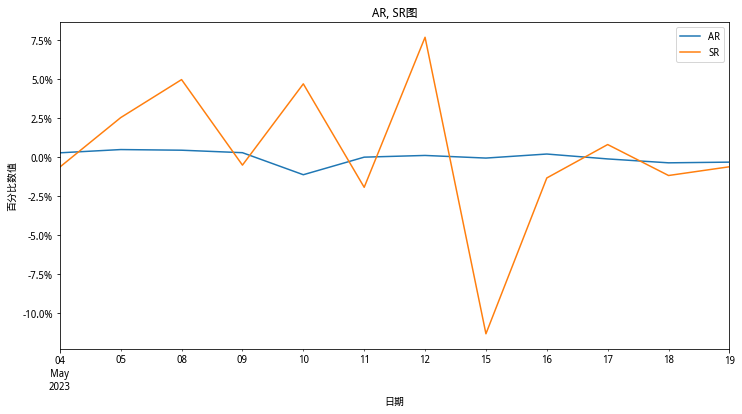

In [40]:
plt.figure(figsize=(12,6))
ax=plt.subplot()
plot.plot(ax=ax)
ax.set(title="AR, SR图", xlabel='日期', ylabel='百分比数值')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))